모델을 어떻게 짜느냐보다 
주어진 문제를 해결하기 위해 어떻게 문제를 설계하고 평가하는지에 대한 전체 프로세스를 위주로 작성

**추천시스템의 목표**
- 유저의 입장
    - 나에게 적절한 아이템을 받고 싶음
    - 유저에게 적절한 아이템 -> 개인화
- 운영자 입장
    - 상품을 적절한 유저에게 팔고 싶음
    - 상품에 적절한 유저를 찾거나, 비슷한 아이템을 찾거나
    - 상품에 적절한 아이템 -> 연관화
    
    
    
    
 - **오늘은 유저별 추천 사용 : 해당 유저에게 어떤 아이템을 추천할 것인가**

**MovieLens 20M Dataset**
- https://www.kaggle.com/grouplens/movielens-20m-dataset?select=movie.csv
- 영화 평점 데이터를 가지고 각 유저, 아이템에 대해서 유사한 콘텐츠 추천하기로 함


**Latent variable**
- 비지도 학습의 클러스터링에서 그룹을 지으면 각 그룹의 의미는 모르지만, 비슷한 애들끼리 뭉쳐짐
- 예를 들어 kmeans, DBscan 등 
- 그러나 유저들을 군집화하면 각 유저들이 어떤 특성을 가졌는지는 따로 확인해봐야 함 
     - 즉, 사후에 따로 해석을 해야 함
- 따라서 의미를 알 수는 없지만 중요한 의미를 가진 벡터<br><br>
- Clustering에서의 군집
- PCA에서 나온 z들<br><br>

- **오늘 추천시스템에서 사용할 것임, 정확히는 ALS모델**<br><br>



**explicit feedback**<br>
- 유저가 정확하게 어떤 아이템에 대해서 평점이 몇이냐 메긴 것<br><br>


**implicit feedback**<br>
- 유저가 좋아하는지 안 좋아하는지 모르는데 구독은 누른경우 
    - 좋아하는 표시는 맞지만 행동에 불가한 것
    - 영상을 보다가 중간에 나간 경우 사후에 전처리를 거쳐서 해당 유저는 영상을 몇 번봤는지 피처를 뽑아내야 함
    
**explicit vs implicit**
- 배민에서도 평점을 남기는 고객은 극소수임
- 따라서 explicit피드백은 적고 구하기 어려움
- implicit은 구하기 쉽지만 평가하기가 어려움<br><br>
- **오늘은 explicit을 쉽게 다룰 것이고**
- **implicit도 rating을 매기는 것처럼 피처로 뽑아줄 것**
- **뽑아준 피처를 넣어주는 방법도 구현할 것**


**추천시스템 종류**
1. 협업 필터링 collaborative filtering(cf)
    - 유저와 아이템(영화)간의 상호작용을 가지고 모델링하는 것
    - **오늘은 cf중 하나인 matrix factorization(mf)를 도입하기 위해 ALS를 사용**
        - ALS는 mf를 실행하는 방법론 중 하나
        - ALS가 가장 많이 사용됨
        - 뉴럴넷, BPR(bayesian personalized ranking), 로지스틱 등등이 있음
        - ALS와 BPR은 작동 방식이 완전히 다름<br><br>
        
2. 콘텐츠 필터링 content filtering
    - 유저나 아이템 자체의 정보를 이용<br><br>

3. hybrid
    - 둘 다 섞어 쓰는 것

# 1. preprocessing

## 1.1데이터 탐색

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir(r"C:\Users\Gram\Desktop\스스로 배우는 데이터사이언스\추천시스템\data")
df = pd.read_csv('rating.csv')

In [3]:
df.head()
# 각 유저가 어떤 아이템에 대해서 어떻게 점수를 매겼는지, 시간은 언제인지 알 수 있음

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
df.info()
# RangeIndex: 20000263면 데이터가 2000만개 정도 -> 나쁘지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    object
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [5]:
df.userId = df.userId.astype(np.int32)
df.movieId = df.movieId.astype(np.int32)
df.rating = (df.rating*2).astype(np.int16) # rating은 0.5~5점 사이이므로 0.5점 때문에 float으로 쓰면 공간 낭비이므로 *2를 해서 0~10점으로 변경해 줌

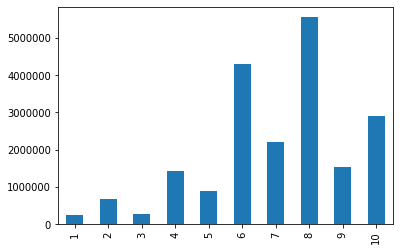

In [6]:
df.rating.value_counts().sort_index().plot.bar()
# 6점과 8점에 대부분이 분포

**유저별로 몇 번씩 평가를 했는지 확인**

In [7]:
# 총 유저의 수 13만 8천명 정도
df.userId.nunique()

138493

In [8]:
user_movie_count = df.groupby('userId').size()
user_movie_count

userId
1         175
2          61
3         187
4          28
5          66
         ... 
138489     38
138490    151
138491     22
138492     82
138493    373
Length: 138493, dtype: int64

In [9]:
user_movie_count.nlargest(10)
# 가장 많이 본 유저는 9254번 평가함 -> 이 유저의 경우 데이터가 풍부함
# 그러나 데이터가 적은 유저들도 존재

userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
74142     5447
34576     5356
131904    5330
83090     5169
59477     4988
dtype: int64

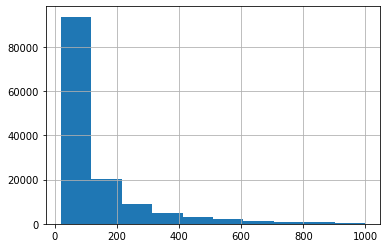

In [10]:
# 데이터가 1000개 미만인 유저들 확인
user_movie_count[user_movie_count<1000].hist()
# 시각화를 하니 대부분의 유저들은 많이 보지 않음

In [11]:
# 중간값을 구해 봄
user_movie_count.median()
# 68개의 영화를 본 유저들이 중간값으로 가장 많음

68.0

In [12]:
# 10개도 안 본 유저 수
(user_movie_count < 10).sum()
# 1명도 없음

0

In [13]:
# 유저들이 본 최소 횟수
user_movie_count.min()
# 최소 20개의 영화는 봤음
# 이미 데이터 자체에서 너무 적은 데이터의 유저는 전처리했을 듯

20

## 1.2 train test split
- 각 유저별로 90%는 train, 10%는 test
- 유저가 본 90개의 영화를 보고 보지 않은 10개가 무엇인지를 맞추는 것이 목표

In [14]:
from tqdm import tqdm # 작동 시간을 보여줌

train = []
test = []

for userId, group in tqdm(df.groupby('userId')):
    group = group.sample(frac = 1) # 유저마다 샘플링을 하는 이유는 어떤 유저는 과하게 데이터가 추출되고, 어떤 유저는 과소하게 데이터가 추출될 것임
                                   # 이걸 방지하기 위해 유저마다 동일한 비율로 샘플링해줌(층화추출)                      
    
    test_len = len(group) // 10   # test 10%로 설정
    test.append(group[:test_len]) 
    
    train.append(group[test_len:]) # test 10%를 제외한 나머지는 train 90%
    
# 유저별로 데이터가 깔끔하지 않는 경우가 있음
# 어떤 유저는 데이터가 1개일 수도
# 카카오아레나에서 플레이리스트 유추하는 경우에도 플레이스트마다 어떤 것은 곡이 1개만 있는 경우도 있음
# 이렇게 데이터가 1개밖에 없으면 이 데이터는 train에 넣어야 할지, test에 넣어야 할지 설정해주거나 제외시켜줘야 함
# 다행히 영화 데이터에서는 최소값이 20이므로 이런 경우는 없음

100%|█████████████████████████████████████████████████████████████████████████| 138493/138493 [06:17<00:00, 366.58it/s]


In [15]:
train_df = pd.concat(train)
test_df = pd.concat(test)

**pickle을 사용하여 간단하게 파일 올림**
- csv로 관리를 하면 파일이 커서 오래 걸림
- csv는 용량도 많이 잡아먹음

In [16]:
train_df.to_pickle('../data/train.pkl')
test_df.to_pickle('../data/test.pkl')